<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

Jupyter notebook housekeeping

In [110]:
pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [111]:
# fix python path if working locally
#from utils import fix_pythonpath_if_working_locally
#
#fix_pythonpath_if_working_locally()
#%matplotlib inline



In [112]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Check whether GPU is available

In [113]:
import torch
torch.cuda.is_available()

False

Load data from prepared local csv files

In [114]:
from darts import TimeSeries
import pandas as pd


Load stock symbols

In [115]:
stocks_file = 'data/ibdgrowth_hist.csv.bz2'

In [116]:
# load into a dataframe with valid market calendar days
stocks_df = pd.read_csv(stocks_file, header=[0, 1], index_col=0)
stocks_df



RYZB                                              \
                          Open       High        Low      Close  Adj Close   
Date                                                                         
1962-01-02 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-03 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-04 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-05 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-08 00:00:00        NaN        NaN        NaN        NaN        NaN   
...                        ...        ...        ...        ...        ...   
2024-01-02 00:00:00  62.000000  62.099998  61.900002  61.950001  61.950001   
2024-01-03 00:00:00  61.990002  62.000000  61.759998  61.810001  61.810001   
2024-01-04 00:00:00  62.020000  62.020000  61.750000  61.840000  61.840000   
2024-01-05 00:00:00  61.849998  61.985001  61.770000  61.980000  61.980000   
2024-01-08 00:00:00  61.950001  61.990002  61.889999  61.912498  61.912498   

                                     PATH                                   \
                        Volume       Open       High        Low      Close   
Date                                                                         
1962-01-02 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-03 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-04 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-05 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-08 00:00:00        NaN        NaN        NaN        NaN        NaN   
...                        ...        ...        ...        ...        ...   
2024-01-02 00:00:00  1582500.0  24.520000  24.613001  23.629999  23.799999   
2024-01-03 00:00:00   949400.0  23.260000  23.440001  22.510000  22.570000   
2024-01-04 00:00:00   780400.0  22.500000  22.760000  22.290001  22.570000   
2024-01-05 00:00:00   458700.0  22.450001  22.895000  22.260000  22.610001   
2024-01-08 00:00:00   284138.0        NaN        NaN        NaN        NaN   

                     ...        TJX                                   \
                     ...        Low      Close  Adj Close     Volume   
Date                 ...                                               
1962-01-02 00:00:00  ...        NaN        NaN        NaN        NaN   
1962-01-03 00:00:00  ...        NaN        NaN        NaN        NaN   
1962-01-04 00:00:00  ...        NaN        NaN        NaN        NaN   
1962-01-05 00:00:00  ...        NaN        NaN        NaN        NaN   
1962-01-08 00:00:00  ...        NaN        NaN        NaN        NaN   
...                  ...        ...        ...        ...        ...   
2024-01-02 00:00:00  ...  92.830002  93.279999  93.279999  5273500.0   
2024-01-03 00:00:00  ...  91.660004  91.699997  91.699997  5337800.0   
2024-01-04 00:00:00  ...  91.309998  92.779999  92.779999  5328000.0   
2024-01-05 00:00:00  ...  91.559998  91.709999  91.709999  4533700.0   
2024-01-08 00:00:00  ...  91.644997  91.978996  91.978996  1635651.0   

                          BLKB                                              \
                          Open       High        Low      Close  Adj Close   
Date                                                                         
1962-01-02 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-03 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-04 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-05 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-08 00:00:00        NaN        NaN        NaN        NaN        NaN   
...                        ...        ...        ...        ...        ...   
2024-01-02 00:00:00  85.910004  86.360001  84.779999  85.570000  85.570000   
2024-01-03 00:00:00  85.330002  85.570000  83.86000

In [117]:
stocks_df.columns.levels[0]

Index(['AAON', 'ABBNY', 'ADSK', 'AEO', 'AER', 'AFYA', 'AGO', 'AIG', 'ALKS',
       'ALKT',
       ...
       'WSM', 'WTFC', 'XP', 'XYL', 'YELP', 'Z', 'ZG', 'ZION', 'ZS', 'ZTS'],
      dtype='object', length=309)

In [118]:
import random

# minimum amount of historical data required to train on a stock series
# stocks that are too new off IPOs, are not a good fit for training this model
min_samples = 1024

stocks_df.index = pd.to_datetime(stocks_df.index)

ticker_dict = {}
stock_tickers = stocks_df.columns.levels[0]
print(type(stock_tickers))


<class 'pandas.core.indexes.base.Index'>


In [119]:
print(list(stock_tickers))

['AAON', 'ABBNY', 'ADSK', 'AEO', 'AER', 'AFYA', 'AGO', 'AIG', 'ALKS', 'ALKT', 'ALLE', 'ALLY', 'ALTR', 'AMD', 'AMGN', 'AMK', 'AMP', 'AMPH', 'AMZN', 'ANET', 'ANF', 'AOS', 'APO', 'ARCO', 'ARES', 'ARM', 'AROC', 'ARVN', 'ASML', 'ASND', 'ASO', 'AVGO', 'AWI', 'AX', 'AXON', 'AXP', 'AZEK', 'AZTA', 'BAC', 'BAM', 'BCO', 'BK', 'BKNG', 'BLBD', 'BLD', 'BLDR', 'BLK', 'BLKB', 'BLX', 'BMI', 'BOH', 'BR', 'BROS', 'BSX', 'BURL', 'BX', 'CADE', 'CAH', 'CAMT', 'CARR', 'CAT', 'CB', 'CCL', 'CDRE', 'CELH', 'CHKP', 'CLS', 'CMG', 'CNM', 'COF', 'COIN', 'COLB', 'COLL', 'COST', 'CRBG', 'CRH', 'CRM', 'CRS', 'CRSP', 'CRWD', 'CSWC', 'CYBR', 'DASH', 'DB', 'DBX', 'DDOG', 'DECK', 'DFH', 'DHI', 'DKS', 'DOCN', 'DOCU', 'DT', 'DUOL', 'DV', 'DXCM', 'EDU', 'ELF', 'EME', 'ENSG', 'ERIE', 'ERJ', 'ESTC', 'ETN', 'EWBC', 'EXPE', 'FBIN', 'FERG', 'FI', 'FICO', 'FITB', 'FIX', 'FLEX', 'FLR', 'FLT', 'FNF', 'FOR', 'FOUR', 'FROG', 'FRPT', 'FRSH', 'FSS', 'FTAI', 'GBDC', 'GCT', 'GDDY', 'GE', 'GEL', 'GEN', 'GFF', 'GLOB', 'GOOG', 'GOOGL', 'GPK'

In [120]:
print(stock_tickers[0])

AAON


In [121]:
# use only 10 stocks while testing impact of covariates on model performance
stock_tickers = random.sample(list(stock_tickers), 10)
for t in stock_tickers:
    stock_full_hist = stocks_df[t].dropna()
    if len(stock_full_hist.index) >= min_samples:
        # we only need Adj Close which takes into account dividends and splits
        ticker_dict[t] = stock_full_hist.drop(columns=['Close'])
        print(f'ticker: {t}')
        print(f'ticker historic data: {ticker_dict[t]}')


ticker: LRN
ticker historic data:                  Open       High        Low  Adj Close     Volume
Date                                                             
2007-12-13  19.750000  25.750000  19.750000  24.549999  4289300.0
2007-12-14  24.700001  25.900000  23.809999  25.500000   329300.0
2007-12-17  25.750000  26.280001  24.740000  24.980000   195100.0
2007-12-18  25.000000  26.000000  25.000000  25.639999    64000.0
2007-12-19  25.500000  30.500000  25.100000  29.000000   170000.0
...               ...        ...        ...        ...        ...
2024-01-02  59.470001  60.590000  59.250000  60.480000   477400.0
2024-01-03  60.689999  61.720001  60.320000  60.450001   592200.0
2024-01-04  60.410000  61.040001  59.520000  59.570000   508500.0
2024-01-05  59.330002  59.330002  57.900002  57.900002   762800.0
2024-01-08  58.029999  58.549999  57.759998  58.099998   134725.0

[4044 rows x 5 columns]
ticker: DBX
ticker historic data:                  Open       High        Low  Adj 

In [122]:
ticker_dict.keys()

dict_keys(['LRN', 'DBX', 'ROST', 'WSM', 'FTAI', 'RELX', 'MEDP', 'COLB'])

In [123]:
type(list(ticker_dict.keys()))

list

In [124]:
list(ticker_dict.keys())[0]

'LRN'

In [125]:
# type(raw_df.index)

In [126]:
# check for missing values
# raw_df.shape[0] - raw_df.dropna().shape[0]

In [127]:
# raw_df

In [128]:

# series = TimeSeries.from_csv('data/market_data.csv', time_col='Date')

ticker_series = {ticker: TimeSeries.from_dataframe(ticker_dict[ticker], freq='B') for ticker in ticker_dict.keys()}
ticker_series

# series = TimeSeries.from_dataframe(raw_df, freq='B')

# raw_df = pd.read_csv(data_file_name, parse_dates=['Date'], index_col=['Date'])

# series = TimeSeries.from_csv(data_file_name, time_col='Date', freq='B')


{'LRN': <TimeSeries (DataArray) (Date: 4193, component: 5, sample: 1)>
 array([[[1.97500000e+01],
         [2.57500000e+01],
         [1.97500000e+01],
         [2.45499992e+01],
         [4.28930000e+06]],
 
        [[2.47000008e+01],
         [2.58999996e+01],
         [2.38099995e+01],
         [2.55000000e+01],
         [3.29300000e+05]],
 
        [[2.57500000e+01],
         [2.62800007e+01],
         [2.47399998e+01],
         [2.49799995e+01],
         [1.95100000e+05]],
 
        ...,
 
        [[6.04099998e+01],
         [6.10400009e+01],
         [5.95200005e+01],
         [5.95699997e+01],
         [5.08500000e+05]],
 
        [[5.93300018e+01],
         [5.93300018e+01],
         [5.79000015e+01],
         [5.79000015e+01],
         [7.62800000e+05]],
 
        [[5.80299988e+01],
         [5.85499992e+01],
         [5.77599983e+01],
         [5.80999985e+01],
         [1.34725000e+05]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2007-12-13 2007-12-14 ... 2024-01-0

Prepare multile series - one per stock ticker

In [129]:
from darts.dataprocessing.transformers import MissingValuesFiller
filler = MissingValuesFiller()

for t, series in ticker_series.items():
    gaps = series.gaps(mode='any')
    print(f'ticker: {t} gaps: \n {gaps}')
    series_filled = filler.transform(series)
    # check for any data gaps
    gaps_filled = series_filled.gaps(mode='any')
    print(f'ticker: {t} gaps after filler: \n {gaps_filled}')
    ticker_series[t] = series_filled



ticker: LRN gaps: 
      gap_start    gap_end  gap_size
0   2007-12-25 2007-12-25         1
1   2008-01-01 2008-01-01         1
2   2008-01-21 2008-01-21         1
3   2008-02-18 2008-02-18         1
4   2008-03-21 2008-03-21         1
..         ...        ...       ...
143 2023-07-04 2023-07-04         1
144 2023-09-04 2023-09-04         1
145 2023-11-23 2023-11-23         1
146 2023-12-25 2023-12-25         1
147 2024-01-01 2024-01-01         1

[148 rows x 3 columns]
ticker: LRN gaps after filler: 
 Empty DataFrame
Columns: [gap_start, gap_end]
Index: []
ticker: DBX gaps: 
     gap_start    gap_end  gap_size
0  2018-03-30 2018-03-30         1
1  2018-05-28 2018-05-28         1
2  2018-07-04 2018-07-04         1
3  2018-09-03 2018-09-03         1
4  2018-11-22 2018-11-22         1
5  2018-12-05 2018-12-05         1
6  2018-12-25 2018-12-25         1
7  2019-01-01 2019-01-01         1
8  2019-01-21 2019-01-21         1
9  2019-02-18 2019-02-18         1
10 2019-04-19 2019-04-19      

In [130]:
# pick the earlies date after which data is available for all covariate series
train_date_start = pd.Timestamp('1990-01-02')

for t, series in ticker_series.items():
    ticker_series[t] = series.slice(train_date_start, series.end_time())
    print(f'ticker: {t} , {ticker_series[t]}')


ticker: LRN , <TimeSeries (DataArray) (Date: 4193, component: 5, sample: 1)>
array([[[1.97500000e+01],
        [2.57500000e+01],
        [1.97500000e+01],
        [2.45499992e+01],
        [4.28930000e+06]],

       [[2.47000008e+01],
        [2.58999996e+01],
        [2.38099995e+01],
        [2.55000000e+01],
        [3.29300000e+05]],

       [[2.57500000e+01],
        [2.62800007e+01],
        [2.47399998e+01],
        [2.49799995e+01],
        [1.95100000e+05]],

       ...,

       [[6.04099998e+01],
        [6.10400009e+01],
        [5.95200005e+01],
        [5.95699997e+01],
        [5.08500000e+05]],

       [[5.93300018e+01],
        [5.93300018e+01],
        [5.79000015e+01],
        [5.79000015e+01],
        [7.62800000e+05]],

       [[5.80299988e+01],
        [5.85499992e+01],
        [5.77599983e+01],
        [5.80999985e+01],
        [1.34725000e+05]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2007-12-13 2007-12-14 ... 2024-01-08
  * component  (component) obje

In [131]:
# add holidays as future covariates
for t, series in ticker_series.items():
    series_with_holidays = series.add_holidays(country_code='US')
    ticker_series[t] = series_with_holidays
    print(f'ticker: {t} , {ticker_series[t]}')


ticker: LRN , <TimeSeries (DataArray) (Date: 4193, component: 6, sample: 1)>
array([[[1.97500000e+01],
        [2.57500000e+01],
        [1.97500000e+01],
        [2.45499992e+01],
        [4.28930000e+06],
        [0.00000000e+00]],

       [[2.47000008e+01],
        [2.58999996e+01],
        [2.38099995e+01],
        [2.55000000e+01],
        [3.29300000e+05],
        [0.00000000e+00]],

       [[2.57500000e+01],
        [2.62800007e+01],
        [2.47399998e+01],
        [2.49799995e+01],
        [1.95100000e+05],
        [0.00000000e+00]],
...
       [[6.04099998e+01],
        [6.10400009e+01],
        [5.95200005e+01],
        [5.95699997e+01],
        [5.08500000e+05],
        [0.00000000e+00]],

       [[5.93300018e+01],
        [5.93300018e+01],
        [5.79000015e+01],
        [5.79000015e+01],
        [7.62800000e+05],
        [0.00000000e+00]],

       [[5.80299988e+01],
        [5.85499992e+01],
        [5.77599983e+01],
        [5.80999985e+01],
        [1.34725000e+05],


In [132]:
# NOTE: tried but model requires numerical values, which complicates the data prep pipeline
#   For now, dropping these symbol categorical values and letting the model itself discover which group/sector a stock belongs to based on price behavior of covariate variables tracking sector indicies
#   The intuition is that the model will be able to discover correlated series patterns similar to the way features are learned in image understanding (and other natural unstructured data understanding).
# add stock ticker symbol as a static covariate to ticker series
# for t, s in ticker_series.items():
#    static_covs_single = pd.DataFrame(data={"symbol": [t]})
#    ticker_series[t] = s.with_static_covariates(static_covs_single)
#    print(f'target series with static covariates: {ticker_series[t]}')
#    print(f'target series static covariates: {ticker_series[t].static_covariates}')

In [133]:
ticker_series

{'LRN': <TimeSeries (DataArray) (Date: 4193, component: 6, sample: 1)>
 array([[[1.97500000e+01],
         [2.57500000e+01],
         [1.97500000e+01],
         [2.45499992e+01],
         [4.28930000e+06],
         [0.00000000e+00]],
 
        [[2.47000008e+01],
         [2.58999996e+01],
         [2.38099995e+01],
         [2.55000000e+01],
         [3.29300000e+05],
         [0.00000000e+00]],
 
        [[2.57500000e+01],
         [2.62800007e+01],
         [2.47399998e+01],
         [2.49799995e+01],
         [1.95100000e+05],
         [0.00000000e+00]],
 ...
        [[6.04099998e+01],
         [6.10400009e+01],
         [5.95200005e+01],
         [5.95699997e+01],
         [5.08500000e+05],
         [0.00000000e+00]],
 
        [[5.93300018e+01],
         [5.93300018e+01],
         [5.79000015e+01],
         [5.79000015e+01],
         [7.62800000e+05],
         [0.00000000e+00]],
 
        [[5.80299988e+01],
         [5.85499992e+01],
         [5.77599983e+01],
         [5.80999985

In [134]:
from darts.dataprocessing.transformers import Scaler

# scale series values within [0,1] range to avoid gradient explosion
#for t, series in ticker_series.items():
#    ser_scaler = Scaler(verbose=True, n_jobs=-1)
#    series_scaled = ser_scaler.fit_transform(series=series)
#    # print(f'ticker: {t} , {series_scaled}')
#    ticker_series[t] = series_scaled
#    print(f'ticker: {t} , {ticker_series[t]}')


In [135]:
# prepare target univariate price series per ticker
target_series = {t: ticker_series[t].univariate_component('Adj Close') for t in ticker_series.keys()}
target_series

{'LRN': <TimeSeries (DataArray) (Date: 4193, component: 1, sample: 1)>
 array([[[24.54999924]],
 
        [[25.5       ]],
 
        [[24.97999954]],
 
        ...,
 
        [[59.56999969]],
 
        [[57.90000153]],
 
        [[58.09999847]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2007-12-13 2007-12-14 ... 2024-01-08
   * component  (component) object 'Adj Close'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'DBX': <TimeSeries (DataArray) (Date: 1512, component: 1, sample: 1)>
 array([[[28.47999954]],
 
        [[30.45000076]],
 
        [[29.89999962]],
 
        ...,
 
        [[28.60000038]],
 
        [[29.15999985]],
 
        [[29.59499931]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2018-03-23 2018-03-26 ... 2024-01-08
   * component  (component) object 'Adj Close'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'ROST

Prepare Past Covariates

In [136]:
# start with target ticker's own adjacent data: Open, High, Low, Volume
# drop Close which is the target series
# drop holidays which will be added later to future covariates
past_covariates = {t: ticker_series[t].drop_columns(col_names=['Adj Close', 'holidays']) for t in ticker_series.keys()}

past_covariates


{'LRN': <TimeSeries (DataArray) (Date: 4193, component: 4, sample: 1)>
 array([[[1.97500000e+01],
         [2.57500000e+01],
         [1.97500000e+01],
         [4.28930000e+06]],
 
        [[2.47000008e+01],
         [2.58999996e+01],
         [2.38099995e+01],
         [3.29300000e+05]],
 
        [[2.57500000e+01],
         [2.62800007e+01],
         [2.47399998e+01],
         [1.95100000e+05]],
 
        ...,
 
        [[6.04099998e+01],
         [6.10400009e+01],
         [5.95200005e+01],
         [5.08500000e+05]],
 
        [[5.93300018e+01],
         [5.93300018e+01],
         [5.79000015e+01],
         [7.62800000e+05]],
 
        [[5.80299988e+01],
         [5.85499992e+01],
         [5.77599983e+01],
         [1.34725000e+05]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2007-12-13 2007-12-14 ... 2024-01-08
   * component  (component) object 'Open' 'High' 'Low' 'Volume'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarch

In [137]:
past_covariates.keys()

dict_keys(['LRN', 'DBX', 'ROST', 'WSM', 'FTAI', 'RELX', 'MEDP', 'COLB'])

LRN past covariates components: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')
DBX past covariates components: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')
ROST past covariates components: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')
WSM past covariates components: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')


Text(0, 0.5, 'Past Covariates')

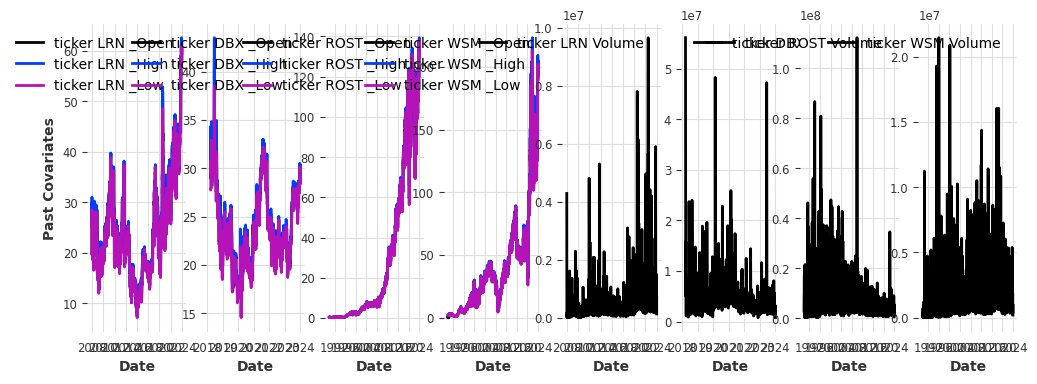

In [138]:
import matplotlib.pyplot as plt


n_plot_samples = 4
# plot sample of past covariates
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples*2, figsize=(12, 4))
for i,t in enumerate(past_covariates.keys()):
    if i < n_plot_samples:
        print(f'{t} past covariates components: {past_covariates[t].columns}')
        past_covariates[t].drop_columns(['Volume']).plot(label=f'ticker {t} ', ax=axes[i])
        past_covariates[t].univariate_component('Volume').plot(label=f'ticker {t} Volume ', ax=axes[n_plot_samples+i])

axes[0].set_ylabel('Past Covariates')


Stack broad market indicators to past covariates

In [139]:
broad_market_df = pd.read_csv('data/broad_market.csv.bz2', header=[0, 1], index_col=0)

# drop Close as redundand
broad_market_df = broad_market_df.drop(columns=['Close'], level=1)

# use a subset of indicies for testing
# broad_market_df = broad_market_df[(broad_market_df.columns[:1])]

#flatten column hierarchy so Darts can use as covariate series
broad_market_df.columns = [f'{i}_{j}' for i, j in broad_market_df.columns]

# CBOE VIX volatility, DYX USD and TNT 10Y Treasury indices do not have meaningful values for Volume
broad_market_df = broad_market_df.drop(columns=['^VIX_Volume', 'DX-Y.NYB_Volume', '^TNX_Volume'])

# fix datetime index type issue
# https://stackoverflow.com/questions/48248239/pandas-how-to-convert-rangeindex-into-datetimeindex
broad_market_df.index = pd.to_datetime(broad_market_df.index)

broad_market_df

,^VIX_Open,^VIX_High,^VIX_Low,^VIX_Adj Close,^TNX_Open,^TNX_High,^TNX_Low,^TNX_Adj Close,^RUT_Open,^RUT_High,...,^NDX_Volume,DX-Y.NYB_Open,DX-Y.NYB_High,DX-Y.NYB_Low,DX-Y.NYB_Adj Close,^SPX_Open,^SPX_High,^SPX_Low,^SPX_Adj Close,^SPX_Volume
Date,,,,,,,,,,,,,,,,,,,,,
1927-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.660000,17.660000,17.660000,17.660000,0.000000e+00
1928-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.760000,17.760000,17.760000,17.760000,0.000000e+00
1928-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.719999,17.719999,17.719999,17.719999,0.000000e+00
1928-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.549999,17.549999,17.549999,17.549999,0.000000e+00
1928-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.660000,17.660000,17.660000,17.660000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-02,13.22,14.23,13.10,13.20,3.969,3.973,3.918,3.946,2012.750000,2032.489990,...,5.791170e+09,101.419998,102.250000,101.339996,102.199997,4745.200195,4754.330078,4722.669922,4742.830078,3.743050e+09
2024-01-03,13.35,14.22,13.33,14.04,3.978,4.008,3.894,3.907,1995.170044,1995.170044,...,5.449950e+09,102.150002,102.730003,102.080002,102.459999,4725.069824,4729.290039,4699.709961,4704.810059,3.950760e+09
2024-01-04,13.93,14.20,13.64,14.13,3.974,4.006,3.971,3.991,1964.349976,1970.540039,...,5.289220e+09,102.459999,102.529999,102.150002,102.419998,4697.419922,4726.779785,4687.529785,4688.680176,3.715480e+09


In [140]:
broad_market_series = TimeSeries.from_dataframe(broad_market_df, freq='B')
broad_market_series = broad_market_series.slice(train_date_start, broad_market_series.end_time())
broad_market_series

<TimeSeries (DataArray) (Date: 8875, component: 27, sample: 1)>
array([[[1.72399998e+01],
        [1.72399998e+01],
        [1.72399998e+01],
        ...,
        [3.51980011e+02],
        [3.59690002e+02],
        [1.62070000e+08]],

       [[1.81900005e+01],
        [1.81900005e+01],
        [1.81900005e+01],
        ...,
        [3.57890015e+02],
        [3.58760010e+02],
        [1.92330000e+08]],

       [[1.92199993e+01],
        [1.92199993e+01],
        [1.92199993e+01],
        ...,
...
        ...,
        [4.68752979e+03],
        [4.68868018e+03],
        [3.71548000e+09]],

       [[1.42399998e+01],
        [1.45799999e+01],
        [1.32900000e+01],
        ...,
        [4.68210986e+03],
        [4.69724023e+03],
        [3.84437000e+09]],

       [[1.40000000e+01],
        [1.41800003e+01],
        [1.30200005e+01],
        ...,
        [4.69981982e+03],
        [4.76354004e+03],
        [2.31306216e+09]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1990-01-02 1990-01-03 ... 2024-01-08
  * component  (component) object '^VIX_Open' '^VIX_High' ... '^SPX_Volume'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [141]:
broad_market_series.gaps()


,gap_start,gap_end,gap_size
0,1999-04-02,1999-04-02,1
1,1999-05-31,1999-05-31,1
2,2000-04-21,2000-04-21,1
3,2000-05-29,2000-05-29,1
4,2000-09-04,2000-09-04,1
...,...,...,...
188,2023-07-04,2023-07-04,1
189,2023-09-04,2023-09-04,1
190,2023-11-23,2023-11-23,1
191,2023-12-25,2023-12-25,1


In [142]:

filler = MissingValuesFiller()

series_filled = filler.transform(broad_market_series)
series_filled.gaps()

,gap_start,gap_end


In [143]:
broad_market_series = series_filled


In [144]:
# scale series to avoid exploding gradients
#bm_scaler = Scaler(verbose=True, n_jobs=-1)
#for c in broad_market_series.columns:
#    broad_market_series[c] = 
#broad_market_series = bm_scaler.fit_transform(series=broad_market_series)
#broad_market_series

In [145]:
print(f'past covariates without broad market indicies: {past_covariates[t].components}')


past covariates without broad market indicies: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')


In [146]:
for t, covs in past_covariates.items():
    bm_sliced = broad_market_series.slice_intersect(covs)
    past_covariates[t] = covs.stack(bm_sliced)
    print(f'past covariates for {t} including broad market indicies: {past_covariates[t].components}')


past covariates for LRN including broad market indicies: Index(['Open', 'High', 'Low', 'Volume', '^VIX_Open', '^VIX_High', '^VIX_Low',
       '^VIX_Adj Close', '^TNX_Open', '^TNX_High', '^TNX_Low',
       '^TNX_Adj Close', '^RUT_Open', '^RUT_High', '^RUT_Low',
       '^RUT_Adj Close', '^RUT_Volume', '^NDX_Open', '^NDX_High', '^NDX_Low',
       '^NDX_Adj Close', '^NDX_Volume', 'DX-Y.NYB_Open', 'DX-Y.NYB_High',
       'DX-Y.NYB_Low', 'DX-Y.NYB_Adj Close', '^SPX_Open', '^SPX_High',
       '^SPX_Low', '^SPX_Adj Close', '^SPX_Volume'],
      dtype='object', name='component')
past covariates for DBX including broad market indicies: Index(['Open', 'High', 'Low', 'Volume', '^VIX_Open', '^VIX_High', '^VIX_Low',
       '^VIX_Adj Close', '^TNX_Open', '^TNX_High', '^TNX_Low',
       '^TNX_Adj Close', '^RUT_Open', '^RUT_High', '^RUT_Low',
       '^RUT_Adj Close', '^RUT_Volume', '^NDX_Open', '^NDX_High', '^NDX_Low',
       '^NDX_Adj Close', '^NDX_Volume', 'DX-Y.NYB_Open', 'DX-Y.NYB_High',
       'DX

In [147]:
print(f'past covariates with broad market indicies: {past_covariates[t].components}')
print(f'past covariates without broad market indicies: {past_covariates[t][0]}')


past covariates with broad market indicies: Index(['Open', 'High', 'Low', 'Volume', '^VIX_Open', '^VIX_High', '^VIX_Low',
       '^VIX_Adj Close', '^TNX_Open', '^TNX_High', '^TNX_Low',
       '^TNX_Adj Close', '^RUT_Open', '^RUT_High', '^RUT_Low',
       '^RUT_Adj Close', '^RUT_Volume', '^NDX_Open', '^NDX_High', '^NDX_Low',
       '^NDX_Adj Close', '^NDX_Volume', 'DX-Y.NYB_Open', 'DX-Y.NYB_High',
       'DX-Y.NYB_Low', 'DX-Y.NYB_Adj Close', '^SPX_Open', '^SPX_High',
       '^SPX_Low', '^SPX_Adj Close', '^SPX_Volume'],
      dtype='object', name='component')
past covariates without broad market indicies: <TimeSeries (DataArray) (Date: 1, component: 31, sample: 1)>
array([[[3.99317694e+00],
        [3.99317694e+00],
        [3.83129191e+00],
        [2.73340000e+04],
        [1.51199999e+01],
        [1.52299995e+01],
        [1.48199997e+01],
        [1.52200003e+01],
        [7.23999977e+00],
        [7.23999977e+00],
        [7.23999977e+00],
        [7.23999977e+00],
        [1.93889

Prepare Future Covariates

In [148]:

future_covariates = {t: ticker_series[t].univariate_component('holidays') for t in ticker_series.keys()}
future_covariates

{'LRN': <TimeSeries (DataArray) (Date: 4193, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2007-12-13 2007-12-14 ... 2024-01-08
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'DBX': <TimeSeries (DataArray) (Date: 1512, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2018-03-23 2018-03-26 ... 2024-01-08
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'ROST': <TimeSeries (DataArray) (Date: 8875, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        

Prepare train and validation splits

In [149]:
val_start = pd.Timestamp('2023-05-05')
train_series = {}
val_series = {}
past_covariates_train = {}
past_covariates_val = {}

for t, target in target_series.items():
    train, val = target.split_before(val_start)
    # there should be no gaps in the training data
    assert(len(train.gaps().index) == 0)
    train_series[t] = train
    val_series[t] = val
    past_train, past_val = past_covariates[t].split_before(val_start)
    # there should be no gaps in the training data
    assert(len(past_train.gaps().index) == 0)
    past_covariates_train[t] = past_train 
    past_covariates_val = past_val



In [150]:
train_series, val_series

({'LRN': <TimeSeries (DataArray) (Date: 4016, component: 1, sample: 1)>
  array([[[24.54999924]],
  
         [[25.5       ]],
  
         [[24.97999954]],
  
         ...,
  
         [[41.29000092]],
  
         [[41.31000137]],
  
         [[40.72000122]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 2007-12-13 2007-12-14 ... 2023-05-04
    * component  (component) object 'Adj Close'
  Dimensions without coordinates: sample
  Attributes:
      static_covariates:  None
      hierarchy:          None,
  'DBX': <TimeSeries (DataArray) (Date: 1335, component: 1, sample: 1)>
  array([[[28.47999954]],
  
         [[30.45000076]],
  
         [[29.89999962]],
  
         ...,
  
         [[20.03000069]],
  
         [[19.87999916]],
  
         [[19.62000084]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 2018-03-23 2018-03-26 ... 2023-05-04
    * component  (component) object 'Adj Close'
  Dimensions without coordinates: sample
  Attributes:
      static_covariates:  N

In [151]:
past_covariates_train, past_covariates_val

({'LRN': <TimeSeries (DataArray) (Date: 4016, component: 31, sample: 1)>
  array([[[1.97500000e+01],
          [2.57500000e+01],
          [1.97500000e+01],
          ...,
          [1.46920996e+03],
          [1.48841003e+03],
          [3.63517000e+09]],
  
         [[2.47000008e+01],
          [2.58999996e+01],
          [2.38099995e+01],
          ...,
          [1.46778003e+03],
          [1.46794995e+03],
          [3.40105000e+09]],
  
         [[2.57500000e+01],
          [2.62800007e+01],
          [2.47399998e+01],
          ...,
  ...
          ...,
          [4.08971997e+03],
          [4.11958008e+03],
          [4.48613000e+09]],
  
         [[4.14599991e+01],
          [4.22900009e+01],
          [4.09700012e+01],
          ...,
          [4.08886011e+03],
          [4.09075000e+03],
          [4.24651000e+09]],
  
         [[4.10400009e+01],
          [4.10400009e+01],
          [4.00900002e+01],
          ...,
          [4.04828003e+03],
          [4.06121997e+03],
   

Plot data splits

Text(0, 0.5, 'Target Series')

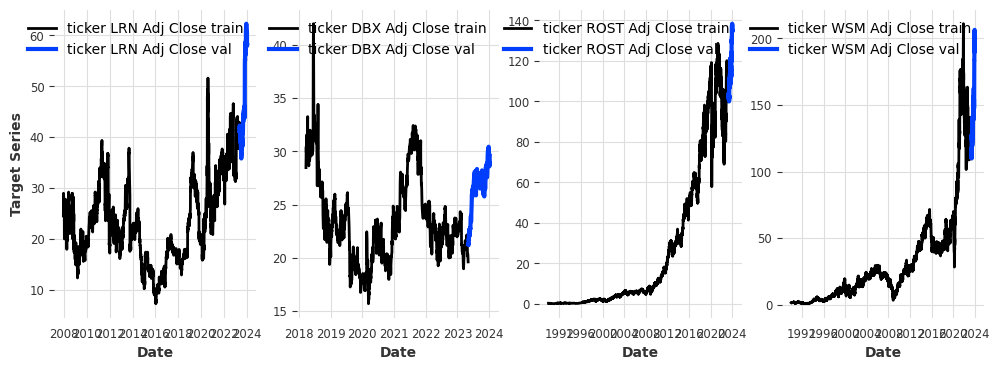

In [152]:
import matplotlib.pyplot as plt

# plot sample of target series
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples, figsize=(12, 4))
for i,t in enumerate(target_series.keys()):
    if i > n_plot_samples-1:
        break
    train_series[t].plot(label=f'ticker {t} {train_series[t].columns[0]} train', ax=axes[i])
    val_series[t].plot(label=f'ticker {t} {train_series[t].columns[0]} val', lw=3, ax=axes[i])

axes[0].set_ylabel('Target Series')


Show seasonalities

Text(0, 0.5, 'Seasonality')

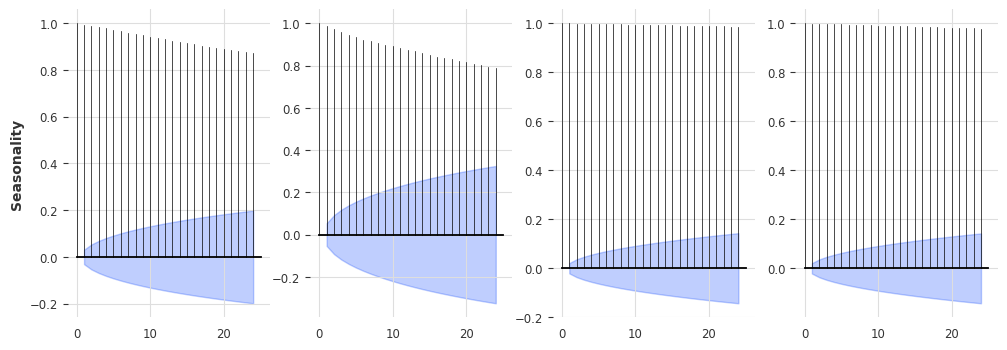

In [153]:
from darts.utils.statistics import plot_acf, check_seasonality

# plot sample of target series
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples, figsize=(12, 4))
for i,t in enumerate(target_series.keys()):
    if i == n_plot_samples:
        break
    plot_acf(train_series[t], alpha=0.05, axis=axes[i])

axes[0].set_ylabel('Seasonality')



Train our current working model

Prepare Encoders that Darts will automatically use for training and inference

In [154]:
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.dataprocessing import Pipeline
# 
scaler = Scaler(verbose=True, n_jobs=-1)

# darts encoder examples: https://unit8co.github.io/darts/generated_api/darts.dataprocessing.encoders.encoders.html#
encoders = {
    'cyclic': {'future': ['dayofweek', 'month', 'quarter']},
    "datetime_attribute": {"future": ["dayofweek", "month", "quarter", "year"]}, 
    'position': {'past': ['relative'], 'future': ['relative']},
    # "transformer": scaler
}



In [155]:
train_history = 252*2 # 252 days in a year with market data
pred_horizon = 21*2 # 21 days in a month with market data
n_epochs = 5 # model training epochs

Model hyperparameter selection

In [156]:
# based on Darts template: https://unit8co.github.io/darts/examples/18-TiDE-examples.html#Model-Parameter-Setup

optimizer_kwargs = {
    "lr": 1e-3,
}

# PyTorch Lightning Trainer arguments
pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 200,
    "accelerator": "auto",
    "callbacks": [],
}

# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999,
}

# early stopping (needs to be reset for each model later on)
# this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 10,
    "min_delta": 1e-3,
    "mode": "min",
}

#
common_model_args = {
    # "input_chunk_length": 12,  # lookback window
    # "output_chunk_length": 12,  # forecast/lookahead window
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    # "likelihood": None,  # use a likelihood for probabilistic forecasts
    # "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    # "force_reset": True,
    "batch_size": 256,
    "random_state": 42,
}

In [157]:
from darts.models import TiDEModel

from darts.utils.likelihood_models import QuantileRegression

saved_model_name = 'data/canswim_model.pt'
model = None

# If available, load the saved model state that performed best on validation set
try:
  print('Loading saved model')
  model = TiDEModel.load(saved_model_name)  
except Exception as e:
  print('Error loading saved model:', e)
  print('Creating a new model')
  model = TiDEModel(
      **common_model_args,
      input_chunk_length=train_history,
      output_chunk_length=pred_horizon,
      use_layer_norm=True,
      add_encoders=None, # encoders,
      dropout=0.1,
      n_epochs=n_epochs,
      use_reversible_instance_norm=True,
      likelihood=QuantileRegression(quantiles=[0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99]),
      model_name=saved_model_name,
  )
  


Loading saved model


In [158]:
from darts.models import RegressionModel
from darts.models.forecasting.forecasting_model import GlobalForecastingModel

# when True, multiple time series are supported
supports_multi_ts = issubclass(model.__class__, GlobalForecastingModel)
supports_multi_ts

True

In [159]:
target_train_list = [series for ticker, series in sorted(train_series.items())]
print(len(target_train_list))
target_val_list = [series for ticker, series in sorted(val_series.items())]
print(len(target_train_list))
past_cov_list = [series for ticker, series in sorted(past_covariates_train.items())]
print(len(past_cov_list))
future_cov_list = [series for ticker, series in sorted(future_covariates.items())]
print(len(future_cov_list))


8
8
8
8


In [160]:
type(target_train_list[0])

darts.timeseries.TimeSeries

In [161]:
print(len(target_train_list[0].time_index))
print(len(past_cov_list[0].time_index))
print(len(future_cov_list[0].time_index))


8058
8058
8235


In [162]:
target_train_list[0].pd_dataframe()

component,Adj Close
Date,
1992-06-16,2.127396
1992-06-17,2.217286
1992-06-18,2.127396
1992-06-19,2.127396
1992-06-22,2.187323
...,...
2023-04-28,20.275757
2023-05-01,19.896059
2023-05-02,18.443724


In [163]:
target_train_list[0].start_time(), target_train_list[0].end_time()

(Timestamp('1992-06-16 00:00:00'), Timestamp('2023-05-04 00:00:00'))

In [164]:
past_cov_list[0].pd_dataframe()

component,Open,High,Low,Volume,^VIX_Open,^VIX_High,^VIX_Low,^VIX_Adj Close,^TNX_Open,^TNX_High,...,^NDX_Volume,DX-Y.NYB_Open,DX-Y.NYB_High,DX-Y.NYB_Low,DX-Y.NYB_Adj Close,^SPX_Open,^SPX_High,^SPX_Low,^SPX_Adj Close,^SPX_Volume
Date,,,,,,,,,,,,,,,,,,,,,
1992-06-16,3.993177,3.993177,3.831292,27334.0,15.120000,15.230000,14.820000,15.220000,7.240,7.240,...,3.263600e+08,85.720001,86.089996,85.419998,85.440002,410.290009,411.399994,408.320007,408.320007,1.944000e+08
1992-06-17,3.993177,3.993177,3.831292,20616.0,15.760000,18.080000,15.740000,18.080000,7.230,7.230,...,3.811400e+08,85.419998,86.150002,85.379997,85.949997,408.329987,408.329987,401.980011,402.260010,2.277600e+08
1992-06-18,3.831292,3.993177,3.831292,36600.0,18.230000,18.530001,17.639999,18.200001,7.190,7.190,...,3.757200e+08,86.010002,86.459999,85.480003,85.610001,402.260010,402.679993,400.510010,400.959991,2.256000e+08
1992-06-19,3.993177,3.993177,3.831292,15752.0,17.430000,17.530001,16.280001,16.309999,7.240,7.240,...,3.551400e+08,85.709999,85.959999,85.599998,85.910004,400.959991,404.230011,400.959991,403.670013,2.334600e+08
1992-06-22,3.939216,3.939216,3.939216,1853.0,14.660000,17.790001,14.640000,16.660000,7.240,7.240,...,3.023800e+08,85.949997,86.129997,85.540001,85.580002,403.640015,403.640015,399.920013,403.399994,1.693700e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-28,21.469999,21.840000,21.230000,2272400.0,17.209999,17.650000,15.720000,15.780000,3.479,3.494,...,5.331380e+09,101.470001,102.169998,101.419998,101.669998,4129.629883,4170.060059,4127.180176,4169.479980,4.087800e+09
2023-05-01,21.520000,21.520000,20.879999,1403300.0,16.410000,16.620001,15.530000,16.080000,3.501,3.576,...,5.168430e+09,101.669998,102.190002,101.620003,102.150002,4166.790039,4186.919922,4164.120117,4167.870117,3.321370e+09
2023-05-02,20.780001,20.900000,19.000000,3001800.0,16.270000,19.809999,16.260000,17.780001,3.532,3.559,...,5.501410e+09,102.150002,102.400002,101.879997,101.959999,4164.100098,4164.100098,4089.719971,4119.580078,4.486130e+09


In [165]:
past_cov_list[0].start_time(), past_cov_list[0].end_time()

(Timestamp('1992-06-16 00:00:00'), Timestamp('2023-05-04 00:00:00'))

In [166]:
n_holidays = future_cov_list[0].pd_dataframe().sum()
n_holidays

component
holidays    320.0
dtype: float64

In [167]:
future_cov_list[0].start_time(), future_cov_list[0].end_time()

(Timestamp('1992-06-16 00:00:00'), Timestamp('2024-01-08 00:00:00'))

In [168]:
# train model
# for i in range(100):
model.fit(target_train_list, epochs=n_epochs, past_covariates=past_cov_list, future_covariates=future_cov_list, verbose=True, num_loader_workers=10, )
          # val_series=target_val_list[0]) # , val_future_covariates=future_cov_list[0]) 



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 4.7 K 
5 | future_cov_projection | _ResidualBlock   | 788   
6 | encoders              | Sequential       | 1.2 M 
7 | decoders              | Sequential       | 1.2 M 
8 | temporal_decoder      | _ResidualBlock   | 4.8 K 
9 | lookback_skip         | Linear           | 14

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


TiDEModel(num_encoder_layers=1, num_decoder_layers=1, decoder_output_dim=16, hidden_size=128, temporal_width_past=4, temporal_width_future=4, temporal_decoder_hidden=32, use_layer_norm=True, dropout=0.1, use_static_covariates=True, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'gradient_clip_val': 1, 'max_epochs': 200, 'accelerator': 'auto', 'callbacks': []}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, batch_size=256, random_state=42, input_chunk_length=504, output_chunk_length=42, add_encoders=None, n_epochs=5, use_reversible_instance_norm=True, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), model_name=data/canswim_model.pt)

In [169]:
# save model checkpoint
model.save(saved_model_name)


In [170]:
# use probabilistic prediction
# see https://unit8co.github.io/darts/userguide/forecasting_overview.html#probabilistic-forecasts
pred = model.predict(pred_horizon, series=target_train_list, mc_dropout=True, num_samples=500, past_covariates=past_cov_list, future_covariates=future_cov_list)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [171]:
pred[0]

<TimeSeries (DataArray) (Date: 42, component: 1, sample: 500)>
array([[[17.73152755, 17.74147817, 18.31655133, ..., 18.32399111,
         18.70314653, 17.4349979 ]],

       [[18.13086243, 17.7124806 , 18.41386021, ..., 18.73824742,
         14.74466195, 15.33108993]],

       [[18.52333779, 18.90255712, 18.59220635, ..., 18.5353988 ,
         19.55964935, 16.61735442]],

       ...,

       [[22.07167244, 22.16028426, 22.66041803, ..., 22.75324785,
         21.83728496, 25.1981088 ]],

       [[22.05876564, 21.92297115, 22.15826181, ..., 24.4945384 ,
         24.32497399, 21.4045175 ]],

       [[20.17646735, 21.61108667, 23.24817864, ..., 23.68526187,
         24.08225042, 21.88465195]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2023-05-05 2023-05-08 ... 2023-07-03
  * component  (component) object 'Adj Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [172]:
pred[0].gaps()

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


,gap_start,gap_end


In [173]:
#pred2_series = target.slice(target.start_time(), val_start+pd.Timedelta(days=60))
#pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred2

In [174]:
#pred3_series = target.slice(target.start_time(), pred2_series.end_time()+pd.Timedelta(days=60))
#pred3 = model.predict(pred_horizon, series=pred3_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred3

In [175]:
#pred4_series = target.slice(target.start_time(), pred3_series.end_time()+pd.Timedelta(days=60))
#pred4 = model.predict(pred_horizon, series=pred4_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred4

In [176]:
#pred5_series = target.slice(target.start_time(), val_start+pd.Timedelta(days=30))
#pred5 = model.predict(pred_horizon, series=pred5_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred5

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


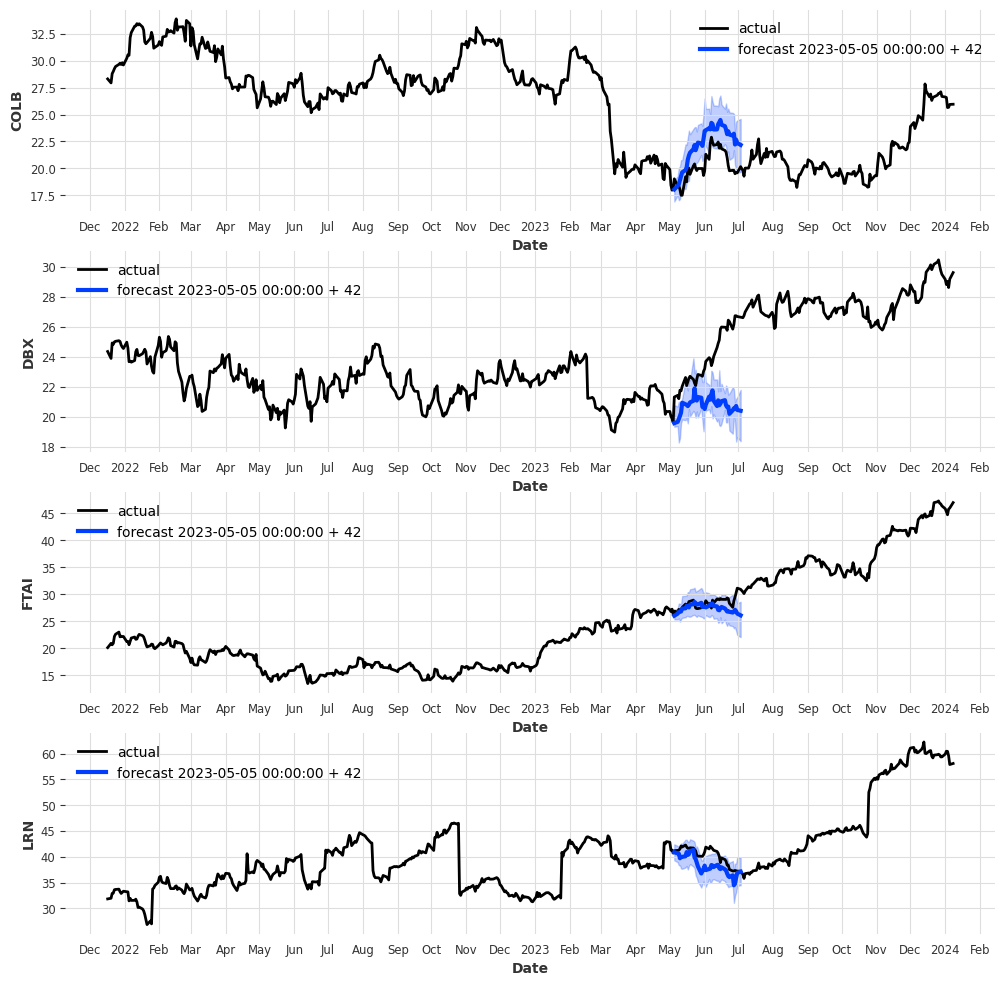

In [177]:
import matplotlib.dates as mdates

# select a reasonable range of train and val data points for convenient visualization of results
actual = {}

fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(12, 12))

for i,t in enumerate(sorted(train_series.keys())):
    if i < n_plot_samples:
        tsliced = target_series[t]
        actual[t] = tsliced.slice(val_start-pd.Timedelta(days=train_history), target.end_time())
        ax = actual[t].plot(label='actual', ax=axes[i])
        pred[i].plot(label=f'forecast {val_start} + {pred_horizon}', linewidth=3, ax=axes[i])
        #pred2.plot(label=f'forecast {pred2_series.end_time()} + {pred_horizon}')
        #pred3.plot(label=f'forecast {pred3_series.end_time()} + {pred_horizon}')
        #pred4.plot(label=f'forecast {pred4_series.end_time()} + {pred_horizon}')
        #pred5.plot(label=f'forecast {pred5_series.end_time()} + {pred_horizon}')
        plt.legend()

        # Major ticks every half year, minor ticks every month,
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(True)
        ax.set_ylabel(f'{t}')




Backtest Model


Backtest model on the full range of test data

In [178]:
from darts.metrics import rmse

def eval_model(model=None, series=None, start=None, past_covariates=None, future_covariates=None, forecast_horizon=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the val portion of the flow series, with a forecast_horizon:
    backtest = model.historical_forecasts(series=series, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=start, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=forecast_horizon,
                                          num_samples=500, # probabilistic forecasting
                                          predict_kwargs={'mc_dropout': True, 'num_loader_workers': 10, 'n_jobs': -1}
                                          )
    
    return backtest


In [179]:
# set the forecast start at a time before the validation date in order to see 
# the difference between predicting on training vs validation data
# predicting up to the validate date should be near match to actuals
# whereas predicting on unseen validate data should have room for improvement
forecast_start = val_start-pd.Timedelta(days=60)
forecast_horizon = pred_horizon # pred_horizon

backtest = eval_model(model=model, series=target_train_list, start=forecast_start, forecast_horizon=forecast_horizon, past_covariates=past_cov_list, future_covariates=future_cov_list)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

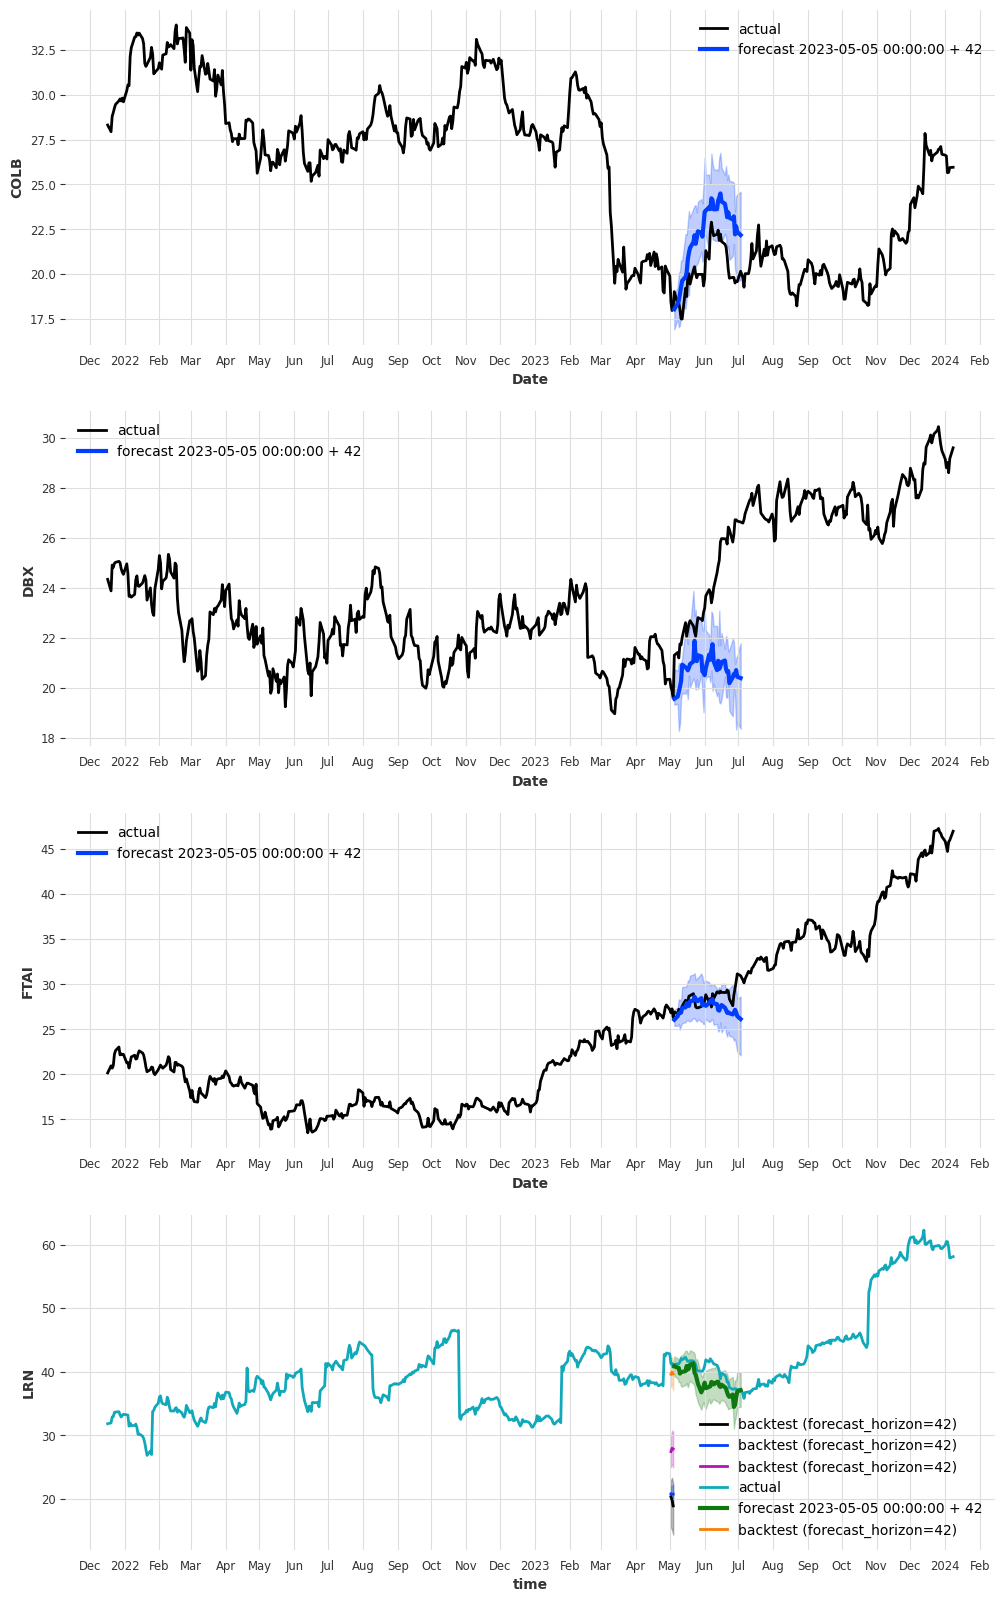

In [182]:

fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(12, 20))

for i,t in enumerate(sorted(train_series.keys())):
    if i < n_plot_samples:
        tsliced = target_series[t]
        ax = actual[t].plot(label='actual', ax=axes[i])
        pred[i].plot(label=f'forecast {val_start} + {pred_horizon}', linewidth=3, ax=axes[i])
        backtest[i].plot(label=f'backtest (forecast_horizon={forecast_horizon})')
        plt.legend()

        # Major ticks every half year, minor ticks every month,
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(True)
        ax.set_ylabel(f'{t}')



In [181]:
print('Backtest RMSE = {}'.format(rmse(target_train_list, backtest)))


Backtest RMSE = [1.6133930472670892, 0.958577372132956, 1.0656463102195137, 1.3761552118330345, 3.582929085522787, 0.8507344270007019, 1.6497188478314593, 4.5922060113190915]
